In [8]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.utils.extmath import randomized_svd
from sklearn.decomposition import TruncatedSVD
from nltk.tokenize import word_tokenize, wordpunct_tokenize, WhitespaceTokenizer, \
                          RegexpTokenizer, sent_tokenize, MWETokenizer
from nltk.util import ngrams
from nltk.chunk import ne_chunk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import gensim

import warnings
import logging
import pickle

%matplotlib inline
pd.options.display.max_columns = 100

In [9]:
def get_sim_from_bk_synopsis_word2vec(word):
    try:
        return gensim_model.most_similar(word.lower())
    except Exception as e:
        return e

In [10]:
# this code doesn't work anymore after upgrading to pandas 0.20.1,
# will get ModuleNotFoundError: No module named 'pandas.indexes'
# with open("cleaned_data.pkl", 'rb') as picklefile: 
#     book_review = pickle.load(picklefile)
book_review = pd.read_pickle("cleaned_data.pkl")

In [11]:
cond = book_review['bk_desc_len'] == 0
book_coll = book_review.loc[~cond, ['bookid', 'bk_desc']].drop_duplicates()
book_coll.set_index('bookid', inplace = True)

bookid_order = book_coll.index
book_coll.tail(1)

,bk_desc
bookid,
17261174,"A little bit Tintin, a little bit Indiana Jone..."


### preprocessing

In [12]:
book_coll['tokens'] = book_coll["bk_desc"].map(lambda x: word_tokenize(x))
book_coll.tail(1)

,bk_desc,tokens
bookid,,
17261174,"A little bit Tintin, a little bit Indiana Jone...","[A, little, bit, Tintin, ,, a, little, bit, In..."


In [13]:
stemmer = LancasterStemmer()
book_coll['stemmed'] = book_coll["tokens"].map(lambda x: " ".join([stemmer.stem(y) for y in x]))
book_coll.tail(1)

,bk_desc,tokens,stemmed
bookid,,,
17261174,"A little bit Tintin, a little bit Indiana Jone...","[A, little, bit, Tintin, ,, a, little, bit, In...","a littl bit tintin , a littl bit indian jon , ..."


### sentiment

In [14]:
sid = SentimentIntensityAnalyzer()

In [15]:
sid_df = book_coll.copy()
sid_df['dict'] = sid_df["stemmed"].map(sid.polarity_scores)
sid_df = pd.concat([sid_df.drop(['dict'], axis=1), sid_df['dict'].apply(pd.Series)], axis=1)
sid_df.tail(1)

,bk_desc,tokens,stemmed,compound,neg,neu,pos
bookid,,,,,,,
17261174,"A little bit Tintin, a little bit Indiana Jone...","[A, little, bit, Tintin, ,, a, little, bit, In...","a littl bit tintin , a littl bit indian jon , ...",-0.4404,0.185,0.726,0.089


In [16]:
sid_df = sid_df.drop(['bk_desc', 'tokens', 'stemmed'], axis = 1)
sid_df.reset_index(inplace = True)
sid_df.tail(1)

,bookid,compound,neg,neu,pos
787,17261174,-0.4404,0.185,0.726,0.089


### more preprocessing

In [17]:
cv = TfidfVectorizer(strip_accents = 'unicode' 
                     , ngram_range = (1, 2)
                     , stop_words = "english"
                     , max_df = 0.5
                     , min_df = 5
                     , norm = 'l2' # important to normalize?
                     )
book_coll = cv.fit_transform(book_coll['stemmed'])
book_coll = pd.DataFrame(book_coll.todense(), columns=[cv.get_feature_names()])
book_coll.tail(1)

,10,18,1945,20th,20th century,abandon,abduc,abl,aboard,abound,abov,abov al,abraham,abraham lincoln,absolv,academy,acc,acceiv,accid,acclaim,accompany,accompl,account,accus,achiev,acquaint,act,ad,adam,addict,addit,adopt,adult,adv,adv set,adv wil,adventure,advers,affair,affect,afoot,afr,afric,aft,aft al,ag,ago,agr,ahead,aid,...,wint,wip,wis,wish,wit,witch,wizard,wo,wolf,wolfgard,wom,won,wond,wood,wor,word,work,work togeth,world,world ar,world ev,world forev,world know,world war,world wher,world wil,worry,wors,worst,wound,wov,writ,wrong,ya,ye,year,year aft,year ago,year lat,year old,year sint,yo,york,york city,york tim,young,young lady,young man,young wom,zomby
787,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.178602,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### get word2vec 

In [18]:
# It barely works on my Mac...
# model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)  

In [19]:
gensim_input = list(book_coll.apply(lambda y: [x for x in book_coll.columns.where(y != 0) if type(x) == str], axis = 1))

In [20]:
gensim_model = gensim.models.Word2Vec(gensim_input, 
                                      seed = 0,
                                      window = 5,
                                      size = np.sqrt(len(gensim_input)),
                                      min_count = 6,
                                      sg = 1,
                                      iter = 5
                                     ) # TODO tune params

- get similarity

In [21]:
get_sim_from_bk_synopsis_word2vec("Tim")

[('thos', 0.9977046251296997),
 ('threat', 0.9969522953033447),
 ('tim bestsel', 0.9969453811645508),
 ('thrilling', 0.9966061115264893),
 ('think', 0.9965169429779053),
 ('togeth', 0.9964728951454163),
 ('thought', 0.9957422614097595),
 ('tour', 0.9956780076026917),
 ('thi world', 0.995520293712616),
 ('thing', 0.9954433441162109)]

- plot word in latent vector space (using first two vectors)

In [22]:
wv_df = dict()
for key, val in gensim_model.wv.vocab.items():
        wv_df[key] = gensim_model.wv[key]
wv_df = pd.DataFrame(wv_df).transpose()
wv_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
10,-0.098386,-0.397289,-0.310279,0.212002,0.062957,0.026009,-0.072640,-0.073426,-0.135216,-0.021665,-0.103028,0.064573,0.056786,-0.026521,-0.154887,0.135418,0.279955,-0.184889,-0.204065,-0.003641,0.256194,-0.050632,0.061879,0.302874,0.222490,0.119631,-0.052745,-0.238069
1945,-0.091119,-0.394989,-0.277655,0.232720,0.026835,0.038947,-0.099784,-0.096190,-0.106050,-0.033502,-0.106023,0.044277,0.089726,-0.003451,-0.147617,0.108862,0.257788,-0.164795,-0.184232,-0.013219,0.265868,-0.065569,0.028181,0.293879,0.217528,0.147641,-0.083122,-0.245101
20th,-0.126488,-0.390759,-0.327277,0.250625,0.082128,0.043996,-0.143283,-0.071311,-0.131194,-0.021779,-0.121146,0.037329,0.089975,-0.041786,-0.166605,0.136495,0.300159,-0.177102,-0.201901,0.018654,0.263796,-0.038497,0.050355,0.314553,0.255219,0.132264,-0.078560,-0.220465
20th century,-0.116793,-0.414076,-0.329676,0.245864,0.087674,0.026843,-0.129513,-0.086626,-0.110490,-0.037646,-0.152964,0.055323,0.099632,-0.005142,-0.192506,0.127682,0.312797,-0.194435,-0.185330,0.017222,0.275715,-0.058754,0.060295,0.341722,0.241932,0.157623,-0.085257,-0.254934
abandon,-0.083966,-0.528606,-0.287107,0.228108,0.036804,-0.001048,-0.064660,-0.128450,-0.152983,-0.050055,-0.142963,0.088499,0.046674,0.026145,-0.248179,0.178055,0.323594,-0.199485,-0.245058,-0.001566,0.312023,-0.119465,0.038139,0.357525,0.215513,0.157401,-0.088167,-0.293500
abduc,-0.082595,-0.494565,-0.314593,0.235877,0.045841,0.039164,-0.088324,-0.112232,-0.160956,-0.065988,-0.133016,0.083754,0.033199,0.022186,-0.220121,0.179437,0.308692,-0.190286,-0.198226,-0.013063,0.321368,-0.104313,0.022944,0.347741,0.210447,0.136210,-0.093689,-0.297689
abl,0.042432,-1.112075,-0.397272,0.374958,0.012742,-0.110168,0.042115,-0.397354,-0.281619,-0.192677,-0.169962,0.268108,-0.081331,0.133860,-0.568308,0.338458,0.607559,-0.417714,-0.400643,0.022145,0.614938,-0.305856,0.039904,0.633140,0.122682,0.221128,-0.081507,-0.515464
aboard,-0.084190,-0.503314,-0.299327,0.264288,0.051442,0.045462,-0.085470,-0.111165,-0.136472,-0.053234,-0.127483,0.083046,0.050984,0.037456,-0.199757,0.184337,0.323052,-0.207506,-0.217458,-0.005762,0.284900,-0.094916,0.025259,0.326234,0.193681,0.162513,-0.101542,-0.273143
abound,-0.102474,-0.490551,-0.312108,0.220311,0.042477,0.021379,-0.080452,-0.101831,-0.127699,-0.051252,-0.126602,0.095520,0.075252,0.039267,-0.182317,0.148097,0.312856,-0.188096,-0.207567,-0.026081,0.281446,-0.096252,0.023198,0.330970,0.214586,0.167731,-0.072583,-0.251779
abov,-0.061944,-0.632648,-0.336700,0.280785,0.063113,-0.021769,-0.068468,-0.171925,-0.232937,-0.113047,-0.132796,0.151801,-0.037322,0.033732,-0.390127,0.234225,0.427741,-0.305873,-0.220614,0.010793,0.429099,-0.150781,0.040307,0.427991,0.146083,0.169941,-0.089298,-0.378640


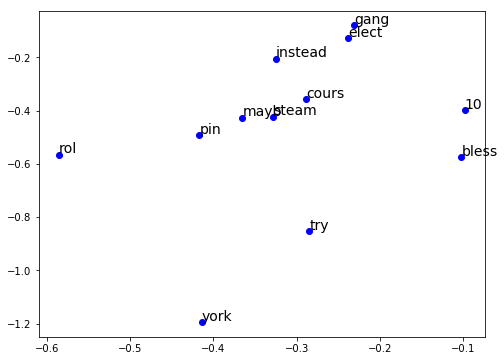

In [23]:
fig = plt.figure(figsize = (8, 6))
tot_words = wv_df.shape[0]
n_words_to_plot = 11
sample = range(0, tot_words, tot_words // n_words_to_plot)
ax = fig.add_subplot(111)
a = wv_df.iloc[sample, 0]
b = wv_df.iloc[sample, 1]
c = wv_df.index[sample]
plt.plot(a, b, "bo")
for tup in zip(a, b, c):                                      
    ax.annotate(tup[2], xy = (tup[0] + 0.0001, tup[1] + 0.005), textcoords='data', fontsize = 14)
plt.show()

### get latent features

In [24]:
init_n_components = min(book_coll.shape) - 1
init_n_components

787

In [25]:
tSVD_model = TruncatedSVD(n_components = init_n_components)
tSVD_model.fit(book_coll)

TruncatedSVD(algorithm='randomized', n_components=787, n_iter=5,
       random_state=None, tol=0.0)

In [26]:
var_ratio_df = pd.DataFrame(tSVD_model.explained_variance_ratio_)
var_ratio_df.columns = ['var_ratio']
var_ratio_df['cum_var_ratio'] = var_ratio_df['var_ratio'].cumsum()
var_ratio_df.head(1)

,var_ratio,cum_var_ratio
0,0.003726,0.003726


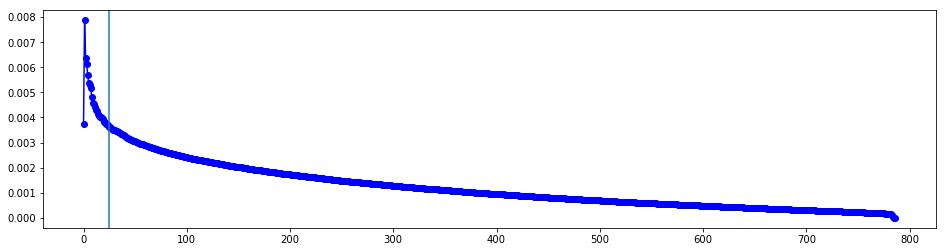

In [27]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['var_ratio'], 'b-o')
plt.axvline(25)
plt.show()

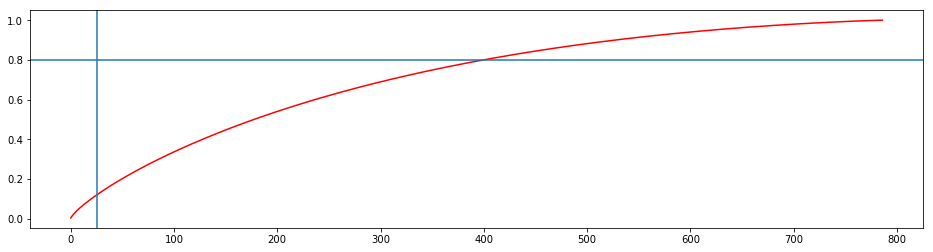

In [28]:
plt.figure(figsize = (16, 4))
plt.plot(var_ratio_df['cum_var_ratio'], 'r-')
plt.axvline(25)
plt.axhline(0.8)
plt.show()

In [29]:
elbow_n_components = 25 # TODO Or 400? Tune this?

In [30]:
U, Sigma, VT = randomized_svd(book_coll, 
                              n_components=elbow_n_components,
                              n_iter=5,
                              random_state=None)
print(book_coll.shape, U.shape, Sigma.shape, VT.shape)

(788, 2254) (788, 25) (25,) (25, 2254)


In [31]:
# reconstruc_recomm_by_stars = pd.DataFrame(np.dot(U, np.dot(np.diag(Sigma), VT)))
# reconstruc_recomm_by_stars.index = recomm_by_stars.index
# reconstruc_recomm_by_stars.columns = recomm_by_stars.columns
# print(reconstruc_recomm_by_stars.shape)
# reconstruc_recomm_by_stars.iloc[:5, :5]

In [32]:
book_latent = pd.DataFrame(U)
book_latent.index = book_coll.index
book_latent.columns = pd.Series(book_latent.columns).map(lambda x: 'bk_latent' + str(x))
book_latent['bookid'] = bookid_order

### pickle additional feature

In [33]:
book_review = book_review.merge(book_latent, how = 'left', on = 'bookid')
book_review.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,bk_latent7,bk_latent8,bk_latent9,bk_latent10,bk_latent11,bk_latent12,bk_latent13,bk_latent14,bk_latent15,bk_latent16,bk_latent17,bk_latent18,bk_latent19,bk_latent20,bk_latent21,bk_latent22,bk_latent23,bk_latent24
19230,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234,0.012278,0.010034,0.003621,-0.005601,-0.002573,-0.011771,0.022249,-0.010397,0.020264,0.003632,-0.027956,-0.036935,-0.0077,0.031474,0.027939,-0.036144,0.0086,-0.006448,-0.048064,-0.027082,-0.029393,0.024207,0.026692,-0.084327,-0.027993


In [34]:
sid_df.columns = ['bookid', 'bk_compound', 'bk_neg', 'bk_neu', 'bk_pos']
book_review = book_review.merge(sid_df, how = 'left', on = 'bookid')
book_review.tail(1)

,bookid,review_like_ct,review_rating,review_desc,userid,review_date,review_yr,review_mon,review_wday_num,review_d_since_1streview,bk_author,bk_avg_rating,bk_desc,bk_n_ratings,bk_n_text_reviews,bk_page_ct,bk_pub_yr,bk_title,user_tot_reviews,dup_ind,bk_desc_len,review_desc_len,bk_latent0,bk_latent1,bk_latent2,bk_latent3,bk_latent4,bk_latent5,bk_latent6,bk_latent7,bk_latent8,bk_latent9,bk_latent10,bk_latent11,bk_latent12,bk_latent13,bk_latent14,bk_latent15,bk_latent16,bk_latent17,bk_latent18,bk_latent19,bk_latent20,bk_latent21,bk_latent22,bk_latent23,bk_latent24,bk_compound,bk_neg,bk_neu,bk_pos
19230,17261174,1,5,"Utterly charming, well paced, written and draw...",1722508,2016-09-23,2016,9,5,1177.0,Tony Cliff,3.94,"A little bit Tintin, a little bit Indiana Jone...",5828,642,122.0,2013.0,Delilah Dirk and the Turkish Lieutenant,1,0.0,169,234,0.012278,0.010034,0.003621,-0.005601,-0.002573,-0.011771,0.022249,-0.010397,0.020264,0.003632,-0.027956,-0.036935,-0.0077,0.031474,0.027939,-0.036144,0.0086,-0.006448,-0.048064,-0.027082,-0.029393,0.024207,0.026692,-0.084327,-0.027993,-0.4404,0.185,0.726,0.089


In [35]:
book_review.columns

Index(['bookid', 'review_like_ct', 'review_rating', 'review_desc', 'userid',
       'review_date', 'review_yr', 'review_mon', 'review_wday_num',
       'review_d_since_1streview', 'bk_author', 'bk_avg_rating', 'bk_desc',
       'bk_n_ratings', 'bk_n_text_reviews', 'bk_page_ct', 'bk_pub_yr',
       'bk_title', 'user_tot_reviews', 'dup_ind', 'bk_desc_len',
       'review_desc_len', 'bk_latent0', 'bk_latent1', 'bk_latent2',
       'bk_latent3', 'bk_latent4', 'bk_latent5', 'bk_latent6', 'bk_latent7',
       'bk_latent8', 'bk_latent9', 'bk_latent10', 'bk_latent11', 'bk_latent12',
       'bk_latent13', 'bk_latent14', 'bk_latent15', 'bk_latent16',
       'bk_latent17', 'bk_latent18', 'bk_latent19', 'bk_latent20',
       'bk_latent21', 'bk_latent22', 'bk_latent23', 'bk_latent24',
       'bk_compound', 'bk_neg', 'bk_neu', 'bk_pos'],
      dtype='object')

In [33]:
book_review.to_pickle("cleaned_w_bknlp.pkl")